In [ ]:
import wandb
wandb.login()
wandb.login(key = "b5d1fbca9d5170f54415e9c5a70ef09cee7a0aec")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m021 (ma23m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


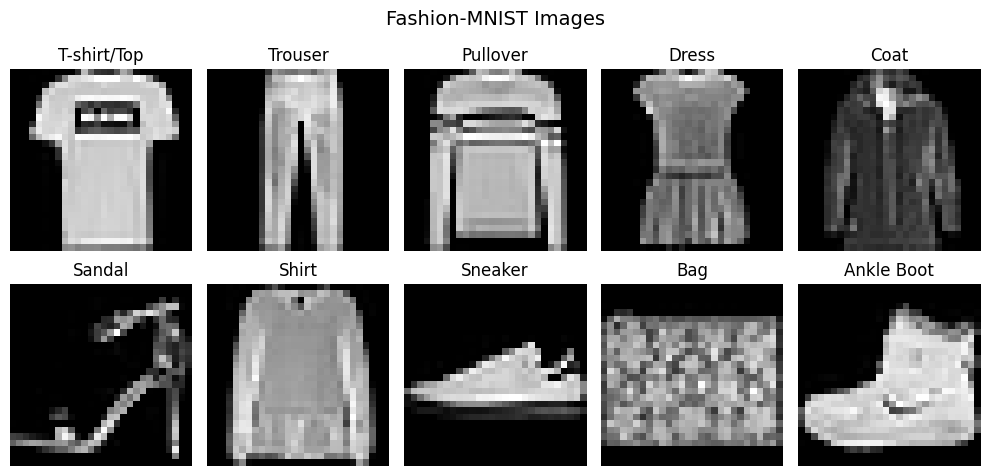

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Initialize Weights & Biases
wandb.init(project="MA23M021_A1")

(x_train, y_train), (_, _) = fashion_mnist.load_data()


class_labels = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]


step_value = 3
index_0_value = 35


sample_images = []
for i in range(10):
    sample_images.append(x_train[np.where(y_train == i)][0])

wandb.log({
    "Fashion-MNIST Samples": [wandb.Image(img, caption=label) for img, label in zip(sample_images, class_labels)],
    "Step": step_value,
    "Index 0": index_0_value
})

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Images", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(class_labels[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from keras.datasets import fashion_mnist

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize input data
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# One-hot encoding function
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

# Activation functions
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Prevent overflow
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Derivatives
def relu_derivative(x):
    return (x > 0).astype(float)

# Xavier/He Initialization for weights
def initialize_parameters(input_size, hidden_layers, output_size=10):
    layers = [input_size] + hidden_layers + [output_size]
    weights = {i: np.random.randn(layers[i-1], layers[i]) * np.sqrt(2/layers[i-1]) for i in range(1, len(layers))}
    biases = {i: np.zeros((1, layers[i])) for i in range(1, len(layers))}
    return weights, biases

# Forward propagation
def forward_propagation(x, weights, biases):
    activations = {0: x}
    z_values = {}

    for i in range(1, len(weights) + 1):
        z_values[i] = np.dot(activations[i-1], weights[i]) + biases[i]
        activations[i] = relu(z_values[i]) if i < len(weights) else softmax(z_values[i])

    return activations, z_values